In [ ]:
#default_exp lightning.core

In [ ]:
#export
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import pytorch_lightning as pl
from pytorch_lightning.metrics.functional.classification import accuracy

import albumentations as A
import pandas as pd

from lib.core import *
from lib.layers import *
from lib.mixmethods import *
from typing import Optional

In [ ]:
from functools import partial
import timm
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2

In [ ]:
#export
def params(m):
    "Return all parameters of `m`"
    return [p for p in m.parameters()]

In [ ]:
#export
class CassavaLightningDataModule(pl.LightningDataModule):
    "lightning-datamodule for cassave leaf disease classification"
    def __init__(self, df_path:str, im_dir:str, curr_fold: int,
                 train_augs: A.Compose, valid_augs: A.Compose, bs: int = 64, num_workers: int=0):
        self.df = load_dataset(df_path, im_dir, curr_fold, True)
        self.train_df: pd.DataFrame = self.df.loc[self.df['is_valid'] == False]
        self.valid_df: pd.DataFrame = self.df.loc[self.df['is_valid'] == True]
        self.train_augs = train_augs
        self.valid_augs = valid_augs
        
        self.train_df = self.train_df.reset_index(inplace=False)
        self.valid_df = self.valid_df.reset_index(inplace=False)
        
        self.bs, self.workers = bs, num_workers
        
    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            self.train_ds = ImageClassificationFromDf(self.train_df, self.train_augs)
            self.valid_ds = ImageClassificationFromDf(self.valid_df, self.valid_augs)
        if stage == "test" or stage is None:
            self.test_ds = ImageClassificationFromDf(self.valid_df, self.valid_augs)
            
    def train_dataloader(self):
        return DataLoader(self.train_ds, shuffle=True, batch_size=self.bs, num_workers=self.workers)

    def val_dataloader(self):
        return DataLoader(self.valid_ds, batch_size=self.bs, num_workers=self.workers)

    def test_dataloader(self):
        return DataLoader(self.test_ds, batch_size=self.bs, num_workers=self.workers)

In [ ]:
def make_show_grid(dl):
    im, batch = next(iter(dl))
    grid = make_grid(im[:4], normalize=True).permute(1, 2, 0).data.numpy()
    plt.figure(figsize=(15,15))
    plt.imshow(grid);

In [ ]:
train_augs = A.Compose([
    A.RandomResizedCrop(224, 224, p=1.0),
    A.RandomBrightness(),
    A.HorizontalFlip(),
    A.IAASharpen(),
    A.Normalize(p=1.0),
    ToTensorV2(p=1.0)])

valid_augs = A.Compose([
    A.Resize(224, 224, p=1.0),
    A.Normalize(p=1.0),
    ToTensorV2(p=1.0)])

csv = "../../leaf-disease-classification-kaggle/data/stratified-data-5folds.csv"
ims = "../../Datasets/cassava/train_images/"
dm = CassavaLightningDataModule(csv, ims, curr_fold=0, train_augs=train_augs, valid_augs=valid_augs,
                               bs=32, num_workers=0)

In [ ]:
dm.train_df.head()

,index,image_id,label,filePath,kfold,is_valid
0,0,2895326283.jpg,Cassava Brown Streak Disease (CBSD),../../Datasets/cassava/train_images/2895326283.jpg,2,False
1,1,255110661.jpg,Cassava Bacterial Blight (CBB),../../Datasets/cassava/train_images/255110661.jpg,4,False
2,4,2033929849.jpg,Cassava Mosaic Disease (CMD),../../Datasets/cassava/train_images/2033929849.jpg,3,False
3,5,3487867690.jpg,Healthy,../../Datasets/cassava/train_images/3487867690.jpg,4,False
4,6,3491458662.jpg,Cassava Mosaic Disease (CMD),../../Datasets/cassava/train_images/3491458662.jpg,2,False


In [ ]:
dm.setup()
train_dl,valid_dl,test_dl = dm.train_dataloader(), dm.val_dataloader(), dm.test_dataloader()

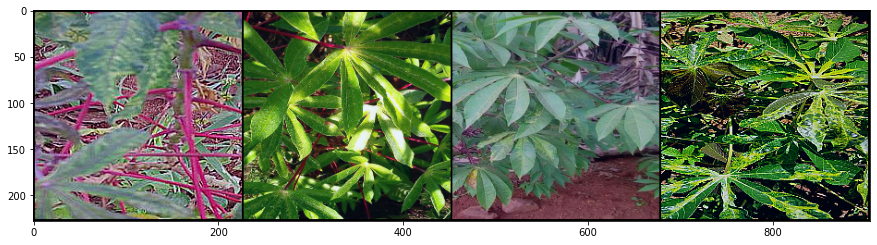

In [ ]:
make_show_grid(train_dl)

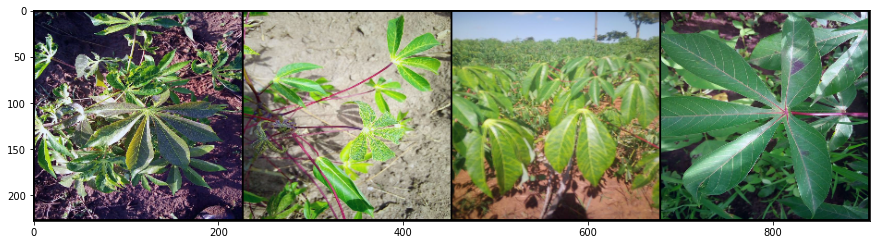

In [ ]:
make_show_grid(valid_dl)

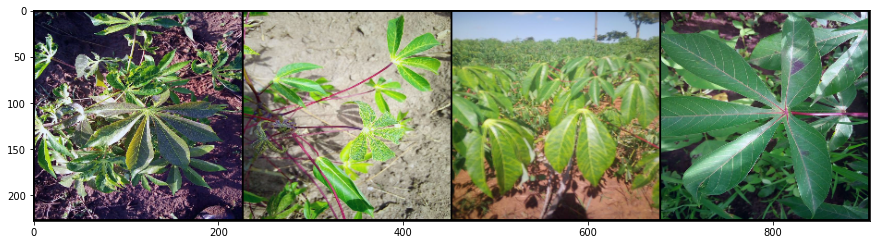

In [ ]:
make_show_grid(test_dl)

In [ ]:
#export
class LightningCassava(pl.LightningModule):
    "LightningModule wrapper for `TransferLearningModel`"
    def __init__(self, model: TransferLearningModel = None, 
                 opt_func: callable = None,
                 lr: float = 1e-03,
                 lr_mult: int = 100,
                 step_after: Optional[str] = None, 
                 frequency: int = 1, 
                 metric_to_track: Optional[str] = None,
                 scheduler: Optional[callable] = None,
                 loss_func: callable = LabelSmoothingCrossEntropy(), 
                 mixmethod: Optional[callable] = partial(Mixup, alpha=0.5)):
        
        super().__init__()
        self.model = model
        self.mix_fn = mixmethod
        self.save_hyperparameters()
        
    def forward(self, xb):
        return self.model(xb)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        
        if self.mix_fn is not None:
            x_mix = self.mix_fn(x, y, self.model)
            y_hat = self(x_mix)
            loss = mixmethod.loss(self.hparams.loss_func, y_hat)
        
        else:
            y_hat = self(x)
            loss = self.hparams.loss_func(y_hat, y)
            
        self.log("train_loss", loss, prog_bar=False)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.hparams.loss_func(y_hat, y)
        
        preds = torch.argmax(y_hat, dim=1)
        acc = accuracy(preds, y)
        
        logs = {'valid_loss': loss, 'accuracy': acc}
        self.log_dict(metrics, prog_bar=True, logger=True,)
        return logs
    
    def test_step(self, batch, batch_idx):
        metrics = self.validation_step(batch, batch_idx)
        metrics = {'test_acc': metrics['accuracy'], 'test_loss': metrics['valid_loss']}
        self.log_dict(metrics)
        
    def configure_optimizers(self):
        ps = self.param_list
        param_list = [
            {'params': ps[0], 'lr': self.hparams.lr/self.hparams.lr_mult},
            {'params': ps[1], 'lr': self.hparams.lr}
        ]
        opt = self.hparams.opt_func(param_list)
        
        if self.hparams.scheduler is not None:
            sch = self.hparams.scheduler(opt)
            sch = {
                'scheduler': sch, 
                'monitor': self.hparams.metric_to_track, 
                'interval': self.hparams.step_after, 
                'frequency': self.hparams.frequency
            }
            
            return [opt], [sch]
        
        else: return [opt]
        
    @property
    def param_list(self):
        return [params(self.model.encoder), params(self.model.fc)]
    
    def save_model_weights(self, path:str):
        state = self.model.state_dict()
        torch.save(state, state)
        
    def load_model_weights(self, path:str):
        state_dict = torch.load(path)
        self.model.load_state_dict(state_dict)

In [ ]:
model = TransferLearningModel(encoder=timm.create_model('resnet18'), cut=-2, c=5, act=nn.ReLU(inplace=True))

m = LightningCassava(
    model=model,
    opt_func=partial(torch.optim.Adam, lr=0.01), 
    scheduler=partial(torch.optim.lr_scheduler.OneCycleLR,max_lr=[0.01/100, 0.01],epochs=4,steps_per_epoch=100), 
    step_after='step', )

In [ ]:
m.configure_optimizers()

([Adam (
  Parameter Group 0
      amsgrad: False
      base_momentum: 0.85
      betas: (0.95, 0.999)
      eps: 1e-08
      initial_lr: 4e-06
      lr: 4.000000000000002e-06
      max_lr: 0.0001
      max_momentum: 0.95
      min_lr: 3.9999999999999996e-10
      weight_decay: 0
  
  Parameter Group 1
      amsgrad: False
      base_momentum: 0.85
      betas: (0.95, 0.999)
      eps: 1e-08
      initial_lr: 0.0004
      lr: 0.0003999999999999993
      max_lr: 0.01
      max_momentum: 0.95
      min_lr: 4e-08
      weight_decay: 0
  )],
 [{'scheduler': <torch.optim.lr_scheduler.OneCycleLR at 0x7fdbf5c29bd0>,
   'monitor': None,
   'interval': 'step',
   'frequency': 1}])

In [ ]:
m.hparams

"frequency":       1
"loss_func":       LabelSmoothingCrossEntropy()
"lr":              0.001
"lr_mult":         100
"metric_to_track": None
"mixmethod":       functools.partial(<class 'lib.mixmethods.Mixup'>, alpha=0.5)
"model":           TransferLearningModel(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin